In [8]:
import sys
from datetime import datetime
from pathlib import Path
from joblib import Parallel, delayed
from typing import Callable

import torch
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

sys.path.append(str(Path("..").resolve()))
from data_handling import load_measurements_npz, MeasurementDataset, MeasurementLoader
from hyper_rbm import SymmetricHyperRBM, train_loop, get_sigmoid_curve

data_dir = Path("measurements")
results_dir = Path("results")
results_dir.mkdir(parents=True, exist_ok=True)

device = "cpu"
print(f"Running on: {device}")
print(f"Saving results to: {results_dir}")

Running on: cpu
Saving results to: results


In [9]:
def compute_mz_abs(samples: torch.Tensor) -> float:
    spins_pm = 1.0 - 2.0 * samples.float()
    mz_per_sample = spins_pm.mean(dim=1)
    return mz_per_sample.abs().mean().item()


def compute_mx(samples: torch.Tensor, log_score_fn: Callable[[torch.Tensor], torch.Tensor]) -> float:
    B, N = samples.shape
    with torch.no_grad():
        log_scores_orig = log_score_fn(samples)
        total_ratios = torch.zeros(B, device=samples.device, dtype=torch.float32)

        for i in range(N):
            flipped = samples.clone()
            flipped[:, i] = 1 - flipped[:, i]
            log_scores_flip = log_score_fn(flipped)
            total_ratios += torch.exp(log_scores_flip - log_scores_orig)

        return (total_ratios / N).mean().item()

In [10]:
SIDE_LENGTH = 4
FILE_SAMPLE_COUNT = 20_000
TRAIN_SAMPLE_COUNT = 20_000

file_suffix = "two"
h_support = [1.00, 3.00, 5.00, 7.00]
h_novel_int = [2.00, 4.00, 6.00]
h_novel_fill = [1.50, 1.80, 2.20, 2.40, 2.60, 2.80, 3.20, 3.40, 3.60, 3.80, 4.20, 4.50, 5.50, 6.50]
h_novel = sorted(h_novel_int + h_novel_fill)

file_names = [f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_h{h:.2f}_{FILE_SAMPLE_COUNT}.npz" for h in h_support]
file_paths = [data_dir / fn for fn in file_names]

samples_per_support = [TRAIN_SAMPLE_COUNT] * len(file_paths)
dataset = MeasurementDataset(file_paths, load_measurements_npz, ["h"], samples_per_support)

print(f"Support points: {h_support}")
print(f"Training samples per support: {TRAIN_SAMPLE_COUNT}")

Support points: [1.0, 3.0, 5.0, 7.0]
Training samples per support: 20000


In [11]:
N_EPOCHS = 50
BATCH_SIZE = 1024
NUM_HIDDEN = 64
HYPER_NET_WIDTH = 64
K_STEPS = 10
GIBBS_NOISE_FRAC = 0.1
INIT_LR = 1e-2
FINAL_LR = 1e-4

SAMPLES_EVAL = 1_000
K_STEPS_EVAL = 10

schedule_tensor_eval = torch.tensor([1.0] * K_STEPS_EVAL, device=device, dtype=torch.float32)

In [12]:
def train_and_evaluate_seed(seed: int) -> pd.DataFrame:
    print(f"Running seed {seed}")

    torch.manual_seed(seed)
    rng = torch.Generator().manual_seed(seed)

    loader = MeasurementLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, rng=rng)

    model = SymmetricHyperRBM(num_v=dataset.num_qubits, num_h=NUM_HIDDEN, hyper_dim=HYPER_NET_WIDTH, k=K_STEPS).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=INIT_LR)
    scheduler = get_sigmoid_curve(INIT_LR, FINAL_LR, N_EPOCHS * len(loader), 0.005)

    model = train_loop(model, optimizer, loader, num_epochs=N_EPOCHS,
                       lr_schedule_fn=scheduler, noise_frac=GIBBS_NOISE_FRAC, rng=rng)

    sweep = sorted([(h, "support") for h in h_support] + [(h, "novel") for h in h_novel], key=lambda x: x[0])

    results = []
    rng_eval = torch.Generator(device=device).manual_seed(seed)

    for h_val, kind in sweep:

        cond_batch = torch.full((SAMPLES_EVAL, 1), h_val, device=device, dtype=torch.float32)
        samples = model.generate(cond_batch, T_schedule=schedule_tensor_eval, rng=rng_eval)

        scorer = lambda v: model.log_score(v, cond_batch)

        mz = compute_mz_abs(samples)
        mx = compute_mx(samples, scorer)

        results.append({"h": float(h_val), "type": kind, "mag_z": float(mz), "mag_x": float(mx)})

    results_df = pd.DataFrame(results)

    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_name = f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_magnet_{file_suffix}_rbm_seed{seed}_{ts}.csv"
    results_df.to_csv(results_dir / save_name, index=False, float_format="%.6e")

    return results_df

In [13]:
SEEDS = list(range(42, 45))

results_list = Parallel(n_jobs=4)(delayed(train_and_evaluate_seed)(s) for s in SEEDS)

all_results_df = pd.concat(results_list, ignore_index=True)
print("\nTraining and magnetization evaluation complete.")


Training and magnetization evaluation complete.


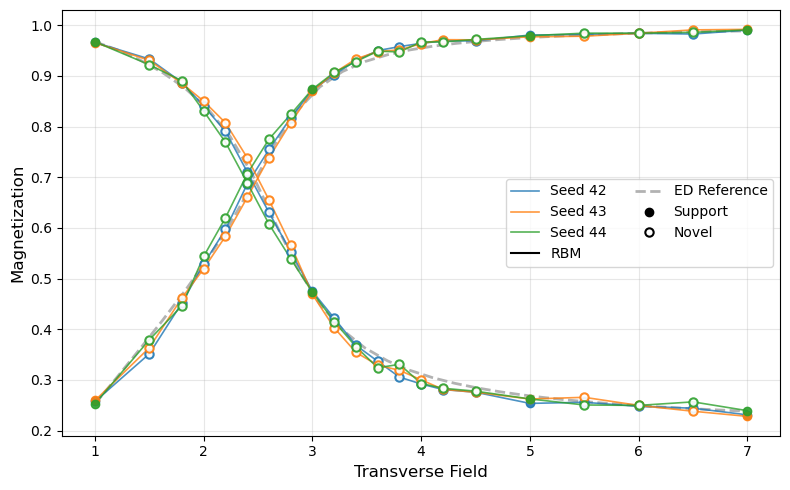

In [14]:
ref_file = Path(f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_magnet_ref.csv")
ref_df = pd.read_csv(ref_file) if ref_file.exists() else None

plt.figure(figsize=(8, 5), dpi=100)

cmap = plt.get_cmap("tab10")

if ref_df is not None and {"h", "mag_z", "mag_x"}.issubset(ref_df.columns):
    plt.plot(ref_df["h"], ref_df["mag_z"], "--", color="gray", linewidth=2, alpha=0.6, zorder=0)
    plt.plot(ref_df["h"], ref_df["mag_x"], "--", color="gray", linewidth=2, alpha=0.6, zorder=0)

alpha_line = 0.80

for i, (seed, df) in enumerate(zip(SEEDS, results_list)):
    df = df.sort_values("h")
    c = cmap(i % 10)

    plt.plot(df["h"], df["mag_z"], "-", color=c, linewidth=1.2, alpha=alpha_line, zorder=5,
             label=f"Seed {seed}")
    plt.plot(df["h"], df["mag_x"], "-", color=c, linewidth=1.2, alpha=alpha_line, zorder=5)

    supp = df[df["type"] == "support"]
    plt.plot(supp["h"], supp["mag_z"], 'o', color=c, markersize=6, alpha=0.9, zorder=6)
    plt.plot(supp["h"], supp["mag_x"], 'o', color=c, markersize=6, alpha=0.9, zorder=6)

    nov = df[df["type"] == "novel"]
    plt.plot(nov["h"], nov["mag_z"], 'o', color=c, markerfacecolor='white',
             markeredgewidth=1.5, markersize=6, alpha=0.9, zorder=6)
    plt.plot(nov["h"], nov["mag_x"], 'o', color=c, markerfacecolor='white',
             markeredgewidth=1.5, markersize=6, alpha=0.9, zorder=6)

handles, labels = plt.gca().get_legend_handles_labels()

dummy_support = Line2D([0], [0], color='black', marker='o', linestyle='', label='Support')
dummy_novel = Line2D([0], [0], color='black', marker='o', markerfacecolor='white',
                     markeredgewidth=1.5, linestyle='', label='Novel')

dummy_rbm = Line2D([0], [0], color='black', linestyle='-', linewidth=1.5, label='RBM')
dummy_ref = Line2D([0], [0], color='gray', linestyle='--', linewidth=2, alpha=0.6, label='ED Reference')

handles.extend([dummy_rbm, dummy_ref, dummy_support, dummy_novel])
labels.extend(["RBM", "ED Reference", "Support", "Novel"])

plt.xlabel("Transverse Field", fontsize=12)
plt.ylabel("Magnetization", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(handles=handles, labels=labels, loc="best", ncol=2)
plt.tight_layout()
plt.show()